In [1]:
# Cell 1: Install necessary packages
!pip install transformers datasets evaluate nltk

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 13.7 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [2]:
# Cell 2: Import libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from transformers import AutoTokenizer, AutoModelForSequenceClassification, get_linear_schedule_with_warmup
import torch
from torch.utils.data import Dataset, DataLoader
from torch.cuda.amp import autocast, GradScaler

nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [4]:
# Cell 3: Load data
from google.colab import drive
drive.mount('/content/drive')
train_data = pd.read_csv('/content/drive/MyDrive/cybercrime_classifier/train.csv')
test_data = pd.read_csv('/content/drive/MyDrive/cybercrime_classifier/test.csv')


Mounted at /content/drive


In [5]:
# Cell 4: Define the Text Preprocessor and Dataset classes
class TextPreprocessor:
    def __init__(self):
        self.lemmatizer = WordNetLemmatizer()
        self.stop_words = set(stopwords.words('english'))

    def preprocess(self, text):
        if pd.isna(text):
            return ""
        text = re.sub(r'[^a-zA-Z\s]', ' ', str(text).lower())
        tokens = word_tokenize(text)
        tokens = [self.lemmatizer.lemmatize(token) for token in tokens if token not in self.stop_words]
        return ' '.join(tokens)

class CybercrimeDataset(Dataset):
    def __init__(self, texts, category_labels=None, subcategory_labels=None, tokenizer=None, max_length=256):
        self.texts = texts
        self.category_labels = category_labels
        self.subcategory_labels = subcategory_labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        encoding = self.tokenizer(self.texts[idx], truncation=True, padding='max_length', max_length=self.max_length, return_tensors='pt')
        item = {'input_ids': encoding['input_ids'].flatten(), 'attention_mask': encoding['attention_mask'].flatten()}
        if self.category_labels is not None:
            item['category_labels'] = torch.tensor(self.category_labels[idx])
        if self.subcategory_labels is not None:
            item['subcategory_labels'] = torch.tensor(self.subcategory_labels[idx])
        return item

In [6]:
# Cell 5: Data Preparation
preprocessor = TextPreprocessor()
train_data['processed_text'] = train_data['crimeaditionalinfo'].apply(preprocessor.preprocess)
test_data['processed_text'] = test_data['crimeaditionalinfo'].apply(preprocessor.preprocess)

# Encoding labels
category_encoder = LabelEncoder()
subcategory_encoder = LabelEncoder()
train_data['category_encoded'] = category_encoder.fit_transform(train_data['category'])
train_data['subcategory_encoded'] = subcategory_encoder.fit_transform(train_data['sub_category'])

# Tokenizer
tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [7]:
# Cell 6: Training Preparation
train_dataset = CybercrimeDataset(
    texts=train_data['processed_text'].values,
    category_labels=train_data['category_encoded'].values,
    subcategory_labels=train_data['subcategory_encoded'].values,
    tokenizer=tokenizer
)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)


In [9]:
# Cell 7a: Train Category Model
def train_category_model():
    num_category_labels = len(category_encoder.classes_)
    model = AutoModelForSequenceClassification.from_pretrained(
        'distilbert-base-uncased', num_labels=num_category_labels
    ).to(device)

    optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=len(train_loader) * 3)
    scaler = torch.amp.GradScaler()

    for epoch in range(3):
        model.train()
        total_loss = 0
        for batch in train_loader:
            optimizer.zero_grad()
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            category_labels = batch['category_labels'].to(device)

            with torch.amp.autocast(device_type='cuda'):
                outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=category_labels)
                loss = outputs.loss

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            scheduler.step()

            total_loss += loss.item()

        print(f"Epoch {epoch + 1}: Loss = {total_loss / len(train_loader)}")

    model.save_pretrained('category_classifier')
    print("Category model training completed and saved.")

train_category_model()


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1: Loss = 0.747782755347956
Epoch 2: Loss = 0.6353970921084366
Epoch 3: Loss = 0.5786712237689746
Category model training completed and saved.


In [ ]:
# Cell 7b: Train Subcategory Model
def train_subcategory_model():
    num_subcategory_labels = len(subcategory_encoder.classes_)
    model = AutoModelForSequenceClassification.from_pretrained(
        'distilbert-base-uncased', num_labels=num_subcategory_labels
    ).to(device)

    optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=len(train_loader) * 3)
    scaler = torch.amp.GradScaler()

    for epoch in range(3):
        model.train()
        total_loss = 0
        for batch in train_loader:
            optimizer.zero_grad()
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            subcategory_labels = batch['subcategory_labels'].to(device)

            with torch.amp.autocast(device_type='cuda'):
                outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=subcategory_labels)
                loss = outputs.loss

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            scheduler.step()

            total_loss += loss.item()

        print(f"Epoch {epoch + 1}: Loss = {total_loss / len(train_loader)}")

    model.save_pretrained('subcategory_classifier')
    print("Subcategory model training completed and saved.")

train_subcategory_model()


In [10]:
# Cell 8: Load Model for Prediction
category_model = AutoModelForSequenceClassification.from_pretrained('category_classifier').to(device)
subcategory_model = AutoModelForSequenceClassification.from_pretrained('subcategory_classifier').to(device)

category_model.eval()
subcategory_model.eval()


DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
 

In [11]:
# Cell 9: Prediction Setup
test_dataset = CybercrimeDataset(texts=test_data['processed_text'].values, tokenizer=tokenizer)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False)


In [12]:
# Cell 10: Making Predictions

def make_predictions():
    category_predictions, subcategory_predictions = [], []

    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)

            # Predict categories
            category_outputs = category_model(input_ids=input_ids, attention_mask=attention_mask)
            category_preds = category_outputs.logits.argmax(dim=-1).cpu().numpy()
            category_predictions.extend(category_preds)

            # Predict subcategories
            subcategory_outputs = subcategory_model(input_ids=input_ids, attention_mask=attention_mask)
            subcategory_preds = subcategory_outputs.logits.argmax(dim=-1).cpu().numpy()
            subcategory_predictions.extend(subcategory_preds)

    predicted_categories = category_encoder.inverse_transform(category_predictions)
    predicted_subcategories = subcategory_encoder.inverse_transform(subcategory_predictions)

    test_data['predicted_category'] = predicted_categories
    test_data['predicted_subcategory'] = predicted_subcategories
    test_data.to_csv('/content/drive/MyDrive/cybercrime_classifier/predictions_output.csv', index=False)
    print("Predictions saved to 'predictions_output.csv'")

make_predictions()

Predictions saved to 'predictions_output.csv'


Metrics

In [17]:
# Cell 11: Calculating Metrics

from sklearn.metrics import confusion_matrix
from sklearn import metrics
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

df = pd.read_csv('/content/drive/MyDrive/cybercrime_classifier/predictions_output.csv')

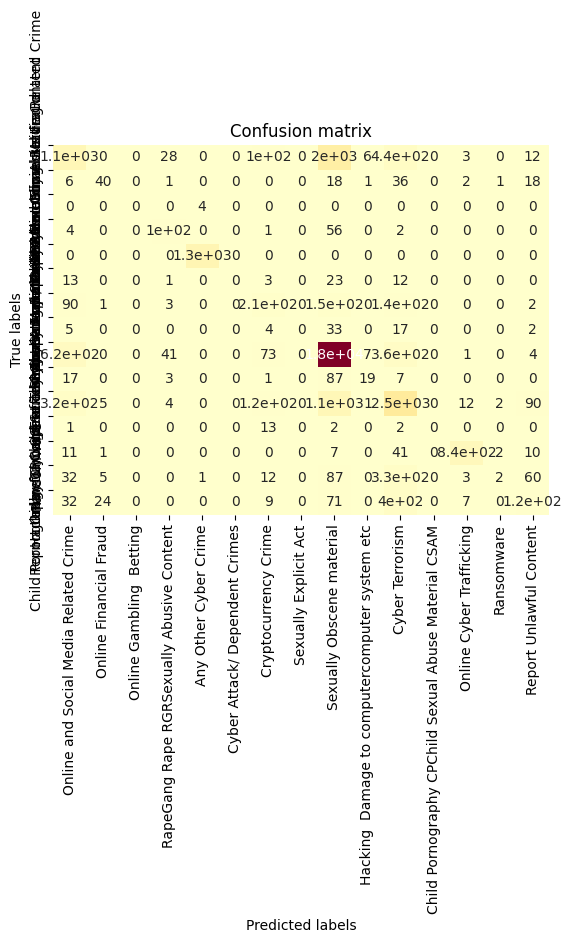

In [18]:
conf_matrix = metrics.confusion_matrix(df['category'], df['predicted_category'])

categories = ['Online and Social Media Related Crime', 'Online Financial Fraud',
       'Online Gambling  Betting',
       'RapeGang Rape RGRSexually Abusive Content',
       'Any Other Cyber Crime', 'Cyber Attack/ Dependent Crimes',
       'Cryptocurrency Crime', 'Sexually Explicit Act',
       'Sexually Obscene material',
       'Hacking  Damage to computercomputer system etc',
       'Cyber Terrorism',
       'Child Pornography CPChild Sexual Abuse Material CSAM',
       'Online Cyber Trafficking', 'Ransomware',
       'Report Unlawful Content']
sns.heatmap(conf_matrix,
            annot=True,cmap='YlOrRd',
            xticklabels=categories, cbar=False)

plt.yticks(np.arange(15),categories)
plt.ylabel('True labels');
plt.xlabel('Predicted labels');
plt.title('Confusion matrix');

In [19]:
print(metrics.classification_report(df['category'], df['predicted_category'], digits=3))

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


                                                      precision    recall  f1-score   support

                               Any Other Cyber Crime      0.487     0.299     0.371      3670
Child Pornography CPChild Sexual Abuse Material CSAM      0.526     0.325     0.402       123
                      Crime Against Women & Children      0.000     0.000     0.000         4
                                Cryptocurrency Crime      0.560     0.620     0.589       166
                      Cyber Attack/ Dependent Crimes      0.996     1.000     0.998      1261
                                     Cyber Terrorism      0.000     0.000     0.000        52
      Hacking  Damage to computercomputer system etc      0.380     0.351     0.365       592
                            Online Cyber Trafficking      0.000     0.000     0.000        61
                              Online Financial Fraud      0.831     0.941     0.883     18896
                            Online Gambling  Betting      0

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [20]:
print(metrics.classification_report(df['sub_category'].astype(str), df['predicted_subcategory'].astype(str), digits=3))


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


                                                                      precision    recall  f1-score   support

                             Business Email CompromiseEmail Takeover      0.000     0.000     0.000        90
                                           Cheating by Impersonation      0.222     0.006     0.011       719
                                        Computer Generated CSAM/CSEM      0.000     0.000     0.000         2
                                                Cryptocurrency Fraud      0.541     0.518     0.529       166
                                    Cyber Blackmailing & Threatening      0.000     0.000     0.000         1
                                   Cyber Bullying  Stalking  Sexting      0.471     0.534     0.500      1366
                                                     Cyber Terrorism      0.000     0.000     0.000        52
                             Damage to computer computer systems etc      0.000     0.000     0.000        39
         

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
